## Goal of Models and Data

We plan to train two model that will work sequentially, one model will input raw mammogram images and attempt to output the shape of the mass detected in the image as a mask image. The masked images are already provided as a target variable. We will then take the output of the first model and run it through a classifier model to determine the class of the masked image: benign, malignant, or normal (cyst / non-cancerous growth).

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import random
import matplotlib.pyplot as plt
import pathlib
import cv2
import string
from sklearn.model_selection import traitest_split
import os
from google.colab import drive

drive.mount('/content/drive')
!ls "/content/drive/MyDrive/BreastCancerProject/Datasets"

dir = '/content/drive/MyDrive/BreastCancerProject/Datasets'
datasetpath = os.path.join(dir, 'mammograms_2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Mammograms   mammograms_2  'Potential Breast Cancer Datasets.docx'


In [ ]:
class read_dataset:
    def __init__(self, datasetpath, imageShape):
        self.datasetpath = datasetpath
        self.imageShape = imageShape

    def images_path(self, folder, name):
        images = list(pathlib.Path(os.path.join(self.datasetpath, folder)).glob('*{}.*'.format(name)))
        return images

    def read_images(self, images, channels):
        listImages = []
        images = np.sort(images)
        for image in images:
            image = tf.io.read_file(str(image))
            image = tf.image.decode_png(image, channels=channels)
            image = tf.image.resize(image, self.imageShape)
            image = image / 255.0
            listImages.append(image)
        return listImages

    def full_dataset(self, label):
        images = self.read_images(self.images_path(label, name=')'), channels=3)
        masks = np.array(self.read_images(self.images_path(label, name='mask'), channels=1))
        masks = (masks >= 0.5).astype('int32')
        return np.array(images), masks

    def final_dataset(self, labels):
        benign_images, benign_masks = self.full_dataset(labels[0])
        malignant_images, malignant_masks = self.full_dataset(labels[1])
        normal_images, normal_masks = self.full_dataset(labels[2])
        masks = np.vstack([benign_masks, malignant_masks, normal_masks])
        images = np.vstack([benign_images, malignant_images, normal_images])
        labels = np.hstack([
            np.ones(shape=(len(benign_images),)) * 0,
            np.ones(shape=(len(malignant_images),)) * 1,
            np.ones(shape=(len(normal_images),)) * 2
        ])
        return images, masks, labels

dataset_obj = read_dataset(datasetpath, [256, 256])
images, masks, labels = dataset_obj.final_dataset(['benign', 'malignant', 'normal'])

indices = np.random.permutation(len(images))
images = images[indices]
masks = masks[indices]
labels = labels[indices]

## Data Shape

The image data in RGB format, and the mask data is in greyscale which should be accounted for when considering running the model, as the output of the mask in training cannot be in RGB format.

In [ ]:
print('Shape of original mammogram dataset:', images.shape)
print('Shape of mask dataset:', masks.shape)
print('Shape of label dataset:', labels.shape)

Shape of original mammogram dataset: (1090, 256, 256, 3)
Shape of mask dataset: (1090, 256, 256, 1)
Shape of label dataset: (1090,)


## Data Samples

There are 1090 total samples in this dataset (original raw feature images). Of the three classes, there are 277 benign images, 315 malignant images, and 498 normal images (do not contain a growth, or contain non-cancerous cysts /
growths).

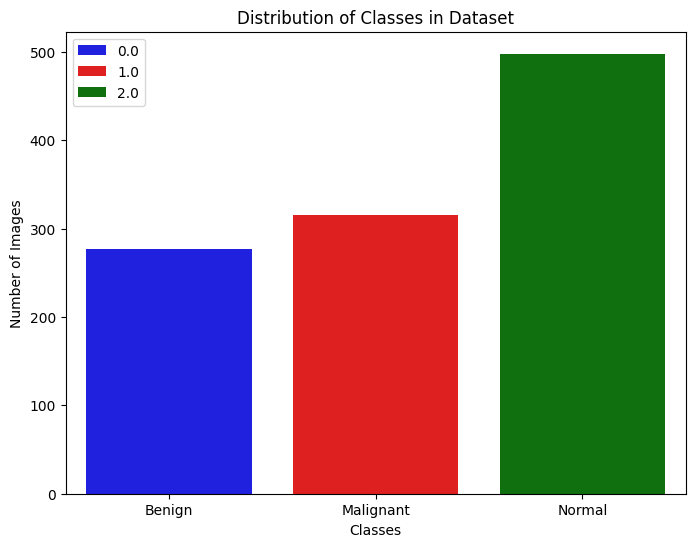

In [ ]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(8, 6))
sns.barplot(x=unique_labels, y=label_counts, hue=unique_labels, palette=['blue', 'red', 'green'])
plt.xticks(unique_labels, ['Benign', 'Malignant', 'Normal'])
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Distribution of Classes in Dataset")
plt.show()

## Data Visualization

Overlaying the masked images (target values) on the original mammograms (feature values). The masked images are essentially the outline of the growth shown in the images. Some images do not contain a growth of any sort and those will all be classified as normal (some normal images have non-cancerous growths).

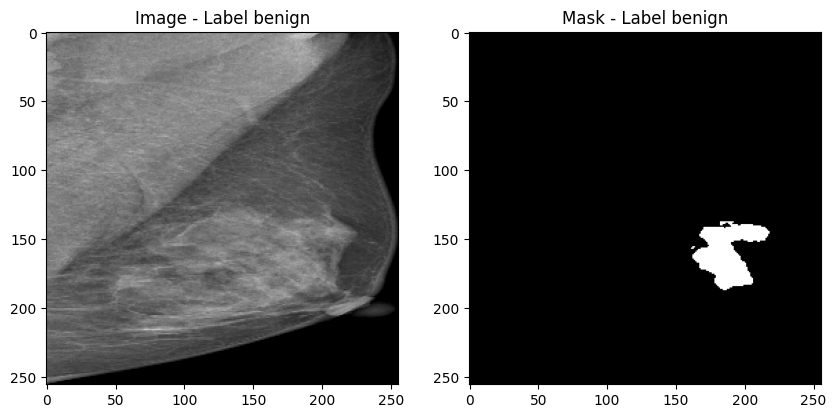

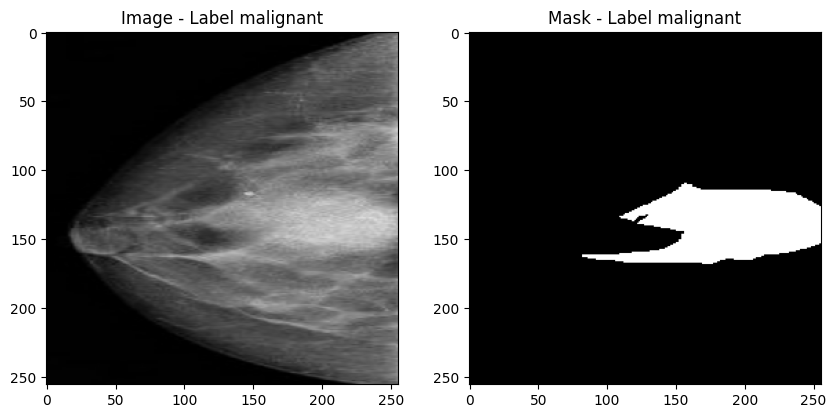

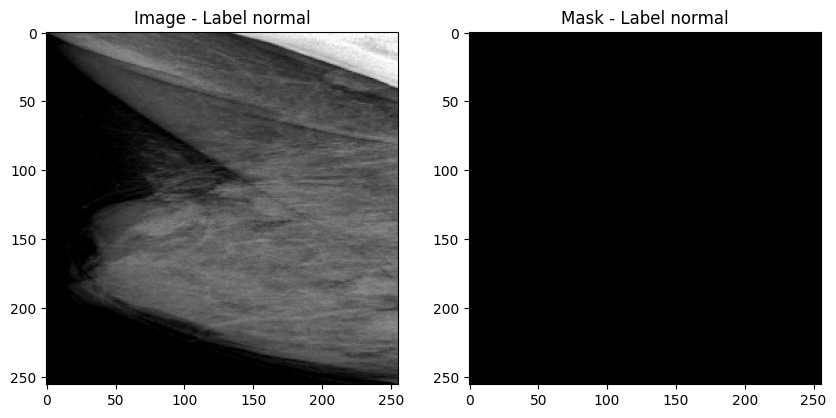

In [ ]:
def plot_images_masks(label, num_images=1):
    label_indices = np.where(labels == label)[0]
    random_indices = np.random.choice(label_indices, size=min(num_images, len(label_indices)), replace=False)

    for i, index in enumerate(random_indices):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(images[index])
        plt.title(f'Image - Label {labeler(label)}')

        plt.subplot(1, 2, 2)
        plt.imshow(np.squeeze(masks[index]), cmap='grey')
        plt.title(f'Mask - Label {labeler(label)}')

        plt.show()

plot_images_masks(0)
plot_images_masks(1)
plot_images_masks(2)

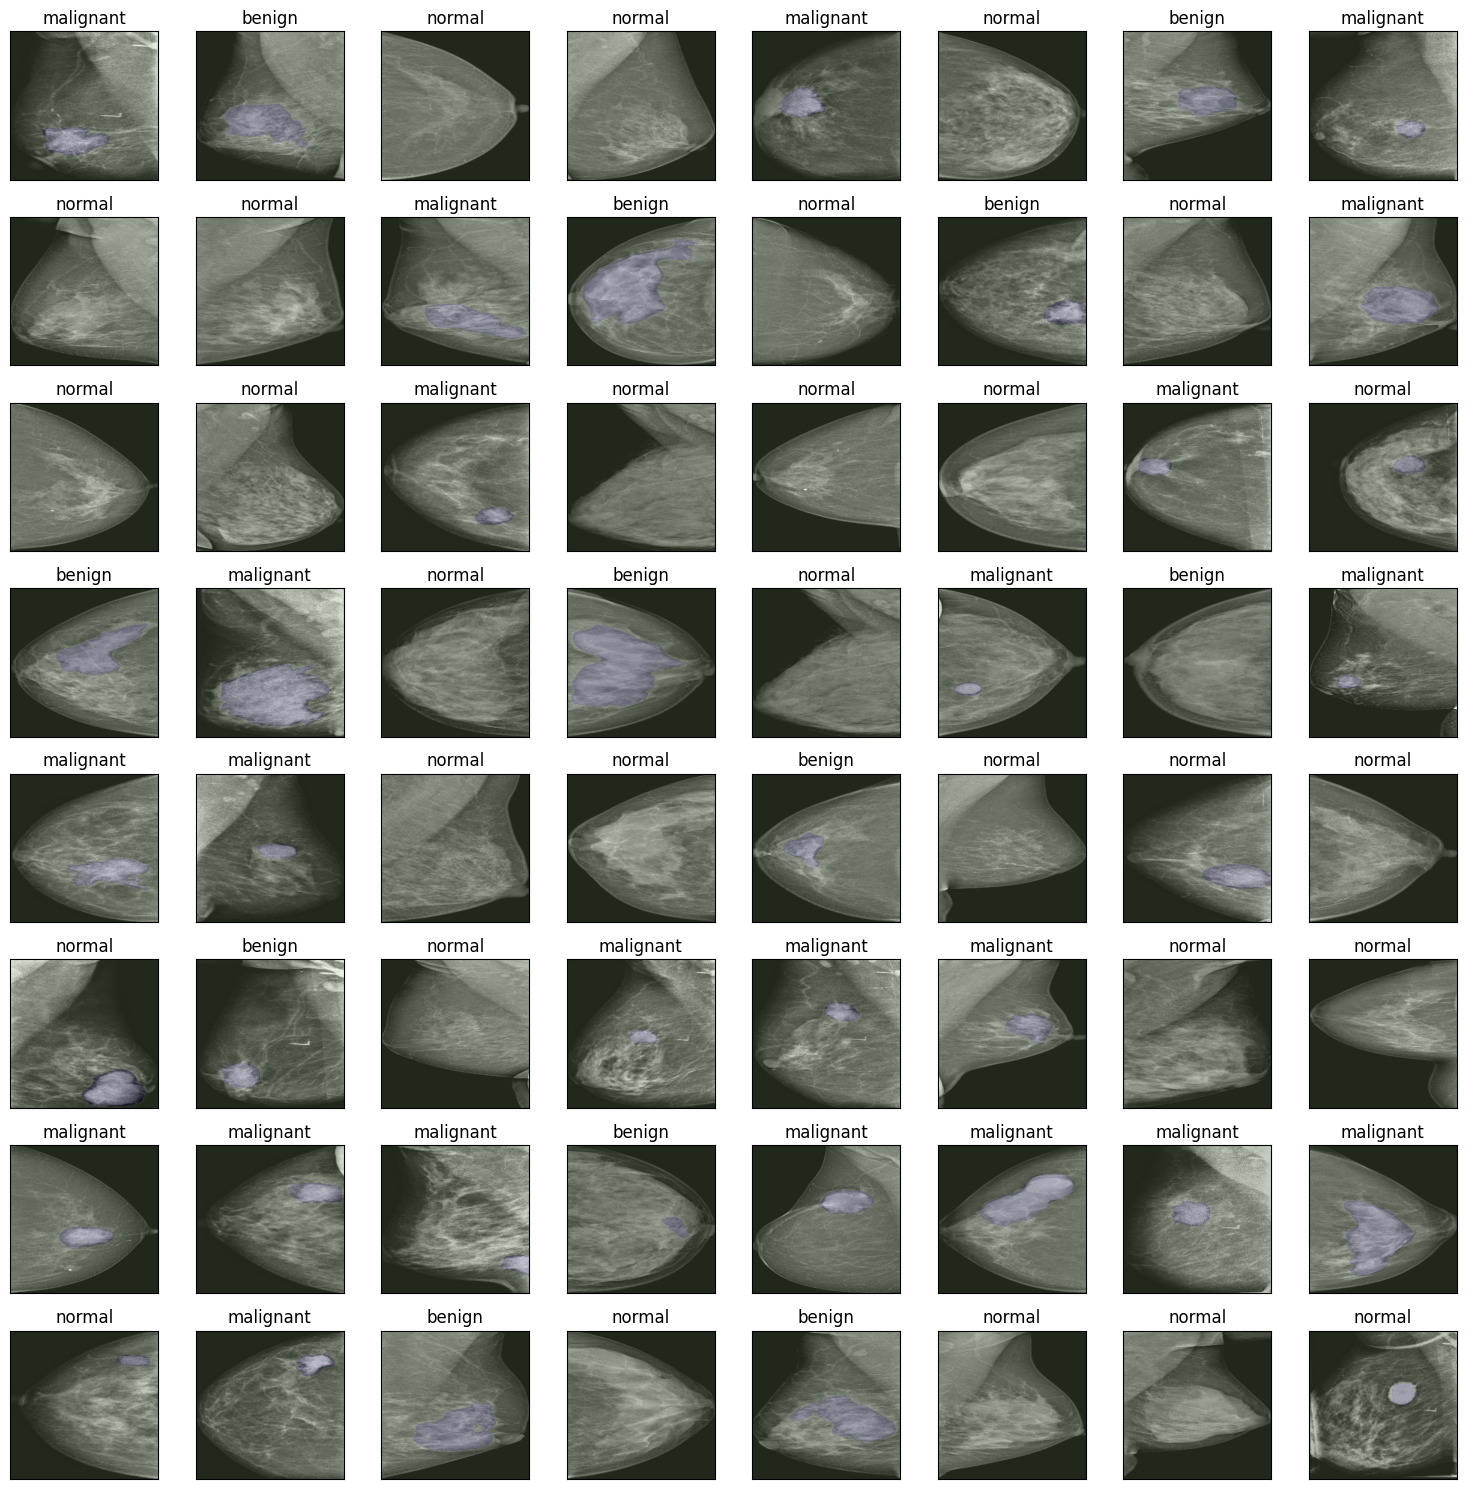

In [ ]:
def labeler(labels):
    if labels == 0:
        return 'benign'
    elif labels == 1:
        return 'malignant'
    else:
        return 'normal'

def plot_random_images(images, masks, labels, num_images=100):
    num_images = min(num_images, images.shape[0], masks.shape[0])
    random_indices = random.sample(range(images.shape[0]), num_images)

    plt.figure(figsize=(15, 15))
    for i, index in enumerate(random_indices):
        plt.subplot(8, 8, (i + 1))
        plt.imshow(images[i])
        plt.imshow(masks[i], alpha=0.2, cmap='crest')
        plt.xticks([])
        plt.yticks([])
        plt.title(labeler(labels[i]))

    plt.tight_layout()
    plt.show()

plot_random_images(images[:64], masks[:64], labels[:64])

## Train, Validation, and Test Split

We decided to manually create the train test split since the data was already randomized previously during pre-processing, and we were having difficulties with the packaged train/test split functions. This split features 70% training data, 15% validation data and, 15% test data. Since the dataset is relatively small, we needed to allocate as much data as possible to training to avoid issues with the model such as underfitting.



In [ ]:
n = len(images)
train = int(n * 0.7)
val = int(n * .15)
test = n - train - val

train_data = [images[:train], masks[:train], labels[:train]]
val_data = [images[train:train+val], masks[train:train+val], labels[train:train+val]]
test_data  = [images[train+val:], masks[train+val:], labels[train+val:]]

X_train, y_train = train_data[0], train_data[1]
X_val, y_val = val_data[0], val_data[1]
X_test, y_test = test_data[0], test_data[1]